In [1]:
# !pip3 install -U ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from ucimlrepo import fetch_ucirepo

In [3]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

In [4]:
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

In [5]:
# Impute missing values using the median of each column
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [6]:
# Scale numerical features using MinMaxScaler
num_cols = X_imputed.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X_imputed[num_cols] = scaler.fit_transform(X_imputed[num_cols])

# Encode categorical variables selectively
# Assuming 'category_col' is the name of a categorical column
# Adjust this part according to your actual categorical columns
cat_cols = X_imputed.select_dtypes(include=['object']).columns
for col in cat_cols:
    if len(X_imputed[col].unique()) == 2:
        le = LabelEncoder()
        X_imputed[col] = le.fit_transform(X_imputed[col])
    else:
        X_imputed = pd.get_dummies(X_imputed, columns=[col])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [8]:
# Build the neural network model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
])

In [9]:
# Configure the model with Adam optimizer and a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=1024, validation_split=0.2)

Epoch 1/30
159/159 [==============================] - 2s 10ms/step - loss: 0.4505 - accuracy: 0.8279 - val_loss: 0.3548 - val_accuracy: 0.8614
Epoch 2/30
159/159 [==============================] - 1s 7ms/step - loss: 0.3403 - accuracy: 0.8608 - val_loss: 0.3340 - val_accuracy: 0.8621
Epoch 3/30
159/159 [==============================] - 1s 7ms/step - loss: 0.3300 - accuracy: 0.8619 - val_loss: 0.3271 - val_accuracy: 0.8636
Epoch 4/30
159/159 [==============================] - 1s 7ms/step - loss: 0.3249 - accuracy: 0.8626 - val_loss: 0.3228 - val_accuracy: 0.8642
Epoch 5/30
159/159 [==============================] - 2s 10ms/step - loss: 0.3216 - accuracy: 0.8634 - val_loss: 0.3201 - val_accuracy: 0.8644
Epoch 6/30
159/159 [==============================] - 1s 7ms/step - loss: 0.3196 - accuracy: 0.8635 - val_loss: 0.3183 - val_accuracy: 0.8644
Epoch 7/30
159/159 [==============================] - 1s 8ms/step - loss: 0.3181 - accuracy: 0.8641 - val_loss: 0.3175 - val_accuracy: 0.8648
Epoc

In [11]:
# Prepare the test dataset using TensorFlow data API
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Evaluate the model on the test dataset to get loss and accuracy
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# To predict and apply a custom threshold of 0.54 for binary classification
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.65).astype(int)  # Applying a threshold

# Calculate accuracy using sklearn's accuracy_score for comparison
custom_accuracy = accuracy_score(y_test, y_pred)
print(f"Custom Threshold Accuracy: {custom_accuracy:.4f}")

793/793 [==============================] - 1s 1ms/step - loss: 0.3086 - accuracy: 0.8681
Test Loss: 0.3086034655570984
Test Accuracy: 0.8681212663650513
1586/1586 [==============================] - 2s 1ms/step
Custom Threshold Accuracy: 0.8640


In [12]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

In [13]:
# Compute Precision-Recall curve and area
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_probs)
pr_auc = average_precision_score(y_test, y_pred_probs)

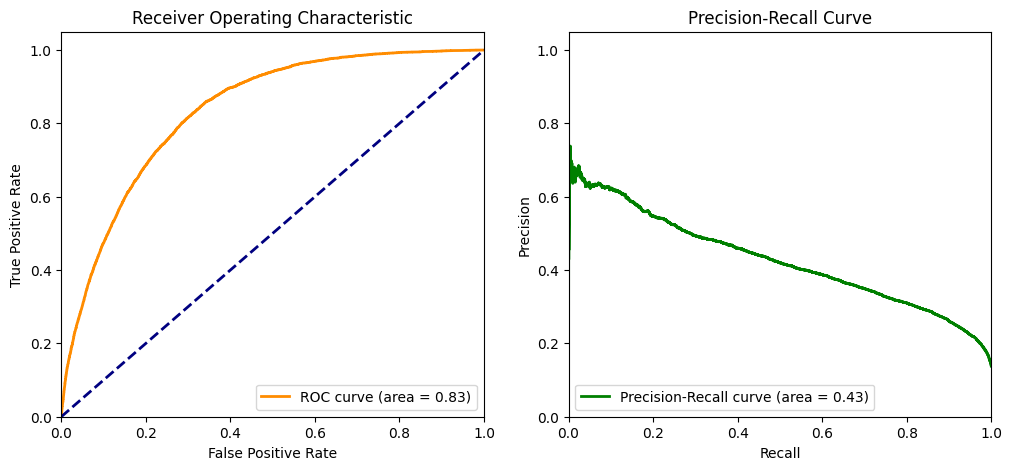

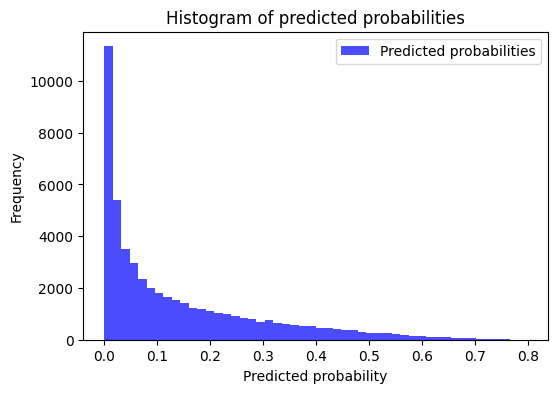

In [14]:
# Plotting the ROC Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plotting the Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.show()

# Plotting histogram of predicted probabilities
plt.figure(figsize=(6, 4))
plt.hist(y_pred_probs, bins=50, color='blue', alpha=0.7, label='Predicted probabilities')
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

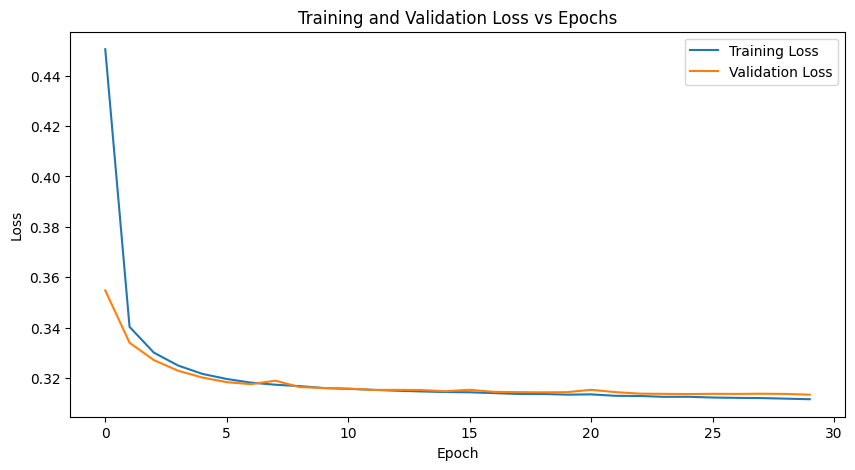

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

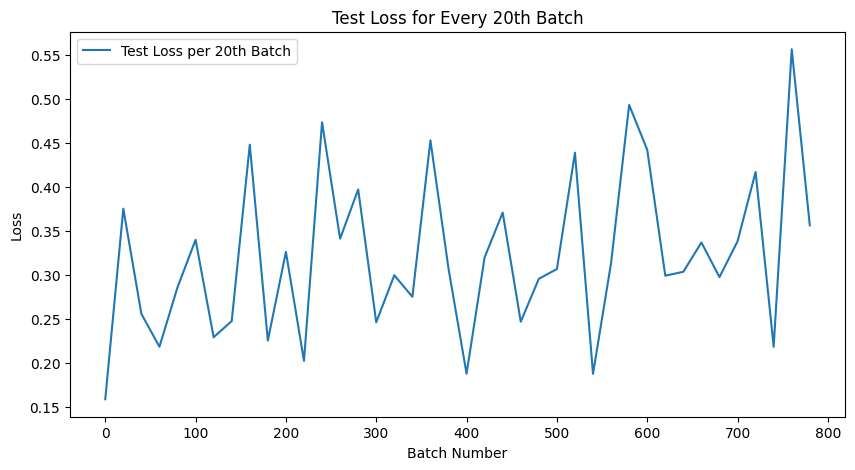

In [16]:
# Initialize the BinaryCrossentropy loss object
loss_fn = BinaryCrossentropy()

# Compute loss per batch, collecting only every 20th batch
test_losses = []
batch_index = 0
for batch_x, batch_y in test_dataset:
    if batch_index % 20 == 0:  # Check if the current batch index is a multiple of 20
        preds = model(batch_x, training=False)  # Get predictions
        loss = loss_fn(batch_y, preds)  # Compute loss
        test_losses.append(loss.numpy())
    batch_index += 1

# Plotting test loss for every 20th batch
plt.figure(figsize=(10, 5))
plt.plot(range(0, batch_index, 20)[:len(test_losses)], test_losses, label='Test Loss per 20th Batch')
plt.title('Test Loss for Every 20th Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()